<img src="assets/sampling.jpg" alt="Data Mining: Sampling and Counting ft. Twitter Data" style="width: 1000px;"/>

# Sampling a Data Stream

For real-world data mining applications, streamed data can come in fast. It's estimated that every single day around 500 million tweets are posted. If we imagine that the data stored for each tweet is on average 1 kilobyte, that is 500 gigabytes daily.  For a large corporation like Twitter, this might be reasonable, but for researchers, data scientists, hobbyists, and smaller companies collecting data, this is exceptionally challenging. This isn't even including the processing and transformations made, which could slow the process down. But suppose we are prepared to collect specific information that is important to us. In that case, we can sample the incoming data to manage the vital information and drastically reduce storage space and processing time. We will be working with two types of sampling, random sampling and reservoir sampling, for this analysis. 

Random sampling is used to generate a subset of individuals chosen from a more extensive set in which a subset of individuals is chosen randomly. Though this method is excellent, it can suffer by missing out on a particular group. There are other ways to handle random sampling, but we will be working with a general lottery system for this analysis. 

Reservoir sampling is used to generate randomized algorithms for choosing a simple random sample, without replacement, of $k$ items from a population of unknown size $n$ in a single pass over the items.

Starting this analysis, we will begin the Tweepy API using my private Twitter API credentials. These can be updated through the `assets/` folder and creating an access.txt in the format:

`consumer_key = 'string'
consumer_secret = 'string'
access_token = 'string'
access_token_secret = 'string'
bearer_token = 'string'`

### extract_emojis()
Additionally, we will declare the `extract_emojis()` function, which uses the library emoji to return a list of all the emojis used in a string.

### retrieve_hashtag_tweets()
This simple function allows us to collect information about a specific hashtag with as many iterations as the Twitter API allows. It then returns a list of JSON objects which are the returned Tweet information.

### retrieve_tweets()
retrieve_tweets takes in a list of JSON Tweet data and returns the text of the Tweet. 

In [1]:
!pip install tweepy
!pip install emoji

In [2]:
import re
import json
import tweepy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from emoji import UNICODE_EMOJI
from collections import defaultdict

In [3]:
'''
Load Twitter API keys and load Tweepy API
'''
key_names, key_dict = ['consumer_key', 'consumer_secret', 'access_token', 'access_token_secret', 'bearer_token'], {}
keys = open('assets/access.txt', 'r')
keys = re.findall(r"'(.*?)'", keys.read())

for i, name in enumerate(key_names):
    key_dict[name] = keys[i]
    
auth = tweepy.OAuthHandler(key_dict['consumer_key'], key_dict['consumer_secret'])
auth.set_access_token(key_dict['access_token'], key_dict['access_token_secret'])
api = tweepy.API(auth)

In [4]:
def extract_emojis(text):
    '''
    Extract all emojis from a str
    '''
    return [ch for ch in text if ch in UNICODE_EMOJI['en']]

def retrieve_hashtag_tweets(hashtag='#nba', n=100):
    '''
    Retrieve the first n of the hashtag. 
    '''
    def limit_handled(cursor):
        n=0
        while True:
            try:
                yield cursor.next()
                n += 1
            except:
                print(f"Reached rate limit after {n} iterations")
                break
        return None
    
    tweets = []

    for tweet in limit_handled(tweepy.Cursor(api.search, q=hashtag).items(n)):
        tweets.append(tweet._json)
    
    return tweets

def retrieve_tweets(tweet_list):
    '''
    Convert Tweet JSON data into list of Tweet text
    '''
    inst_list = []
    for tweet in tweet_list:
        inst_list.append(tweet['text'])
        
    return inst_list

In [5]:
tweets_json = retrieve_hashtag_tweets('#nba', 2000)

Reached rate limit after 2000 iterations


In [6]:
tweets = retrieve_tweets(tweets_json)
tweets[0:5]

['#NBA\xa0\xa0\xa0\xa0PICKS 7/11\n\nGiannis u32.5 (-120)\n\n🔗 Premium picks: \nhttps://t.co/3Wx8ZVmj2S\n\n#nba\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0… https://t.co/KtdltZa3oa',
 'RT @OddsShark: Who is the most overpaid player in the NBA? \n\n#NBATwitter #NBA',
 'RT @Dee_Black_MMA_: Isaiah Austin and Royce White can both ball. Shame their conditions don’t allow them to be in the @nba #nba #big3 #isai…',
 'RT @NotRickFlair: ❤️\u200d🔥Giveaway Alert❤️\u200d🔥\nWant to win a @SewerRats_NFT ? Giving it to a random follower!\n\nTo win:\n1⃣Follow @NotRickFlair \n2⃣…',
 'RT @NotRickFlair: ❤️\u200d🔥Giveaway Alert❤️\u200d🔥\nWant to win a @SewerRats_NFT ? Giving it to a random follower!\n\nTo win:\n1⃣Follow @NotRickFlair \n2⃣…']

# Random Sampling
Random sampling is one of the simplest forms of collecting data from the total population. With random sampling, each Tweet has an equal opportunity to being added to the sample. Unfortunately, it is easy for otherwise essential data to be lost with this method as it relies on chance. Running this class multiple times results in quite significant differences. 

Creating `RandomSampler` contains two functions, `do_sampling` and `_process_new_item.` `do_sampling` iterates through tweets in the given stream and generates a random number compares it to the passed in the threshold, we are using `0.1` in this analysis. `_process_new_item` passes the Tweet into `extract_emojis`, generating a list of emojis which is added to the self.counts. 

In [7]:
class RandomSampler:
    '''
    Generate a subset of individuals chosen from a larger set in which a subset of individuals are chosen randomly.
    '''
    def __init__(self, in_sample_prob):
        self.in_sample_prob = in_sample_prob
        self.sample, self.counts = list(), defaultdict(int)
    
    def _process_new_item(self, item):
        '''
        Applies random sampling to a newly arrived item
        '''
        self.sample.append(item)
        emojis = extract_emojis(item)
        for emoji in emojis:
            self.counts[emoji] = self.counts.get(emoji, 0) + 1
        
    def do_sampling(self, stream):
        '''
        Iterates over a stream and performs random sampling
        '''
        self.sample.clear() # clear the existing sample
        self.counts.clear() # clear the existing counts
        
        for item in stream:
            if random.uniform(0, 1) < in_sample_prob:
                self._process_new_item(item)
            
            yield self.sample.copy(), self.counts.copy()

In [8]:
in_sample_prob = 0.1
rand_sample = RandomSampler(in_sample_prob)

for _ in rand_sample.do_sampling(tweets):
    pass

sorted_counts = {emoji: rand_sample.counts[emoji] for emoji in sorted(rand_sample.counts.keys(), key=rand_sample.counts.get, reverse=True)}
print(sorted_counts)

{'❤': 22, '🔥': 19, '🏀': 17, '🗣': 16, '😂': 6, '👏': 5, '🏾': 5, '🏆': 4, '🔔': 4, '🔃': 4, '👀': 4, '✅': 4, '👇': 3, '👨': 3, '🦱': 3, '🏿': 3, '😭': 3, '🏽': 2, '✍': 2, '🏁': 2, '🔌': 2, '🔋': 2, '🚨': 2, '🔵': 2, '🗓': 2, '🐐': 1, '🤗': 1, '📰': 1, '💥': 1, '🤔': 1, '📲': 1, '🎫': 1, '👩': 1, '🏻': 1, '😬': 1, '😳': 1, '😱': 1, '🚴': 1, '⚽': 1, '🎾': 1, '🥶': 1, '🛑': 1, '🙌': 1, '🦍': 1, '📝': 1, '📄': 1, '🎥': 1, '⚠': 1, '\U0001f9a7': 1, '🧬': 1, '🦚': 1, '🎬': 1, '📺': 1, '📡': 1, '🎙': 1, '🌅': 1, '🖼': 1, '⁉': 1, '✨': 1, '☺': 1, '💸': 1, '🎉': 1, '🌞': 1, '🦌': 1}


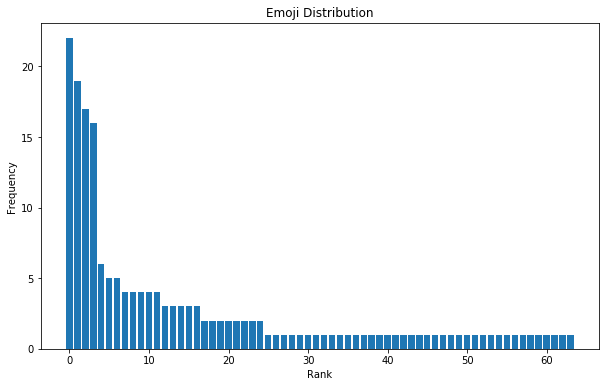

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_counts)), sorted_counts.values())
ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")
ax.set_title("Emoji Distribution")

del fig, ax

# Reservoir Sampling
Reservoir sampling is much more complex than random sampling but still carries some of the same traits. Though more complex, the algorithm is still relatively simple and can process very quickly. As mentioned above, reservoir sampling is used to generate randomized algorithms for choosing a simple random sample, without replacement, of $k$ items from a population of unknown size $n$ in a single pass over the items.

Creating `ReservoirSampler` contains also two functions, `_process_new_item` and `do_sampling`. Both functions work slightly differently from the `RandomSampler` functions defined above. `do_sampling` enumerates through the streamed data; if the sample index is smaller than the sample_size, it automatically gets added in. It must fill this sample size before it moves to the lottery system. Once reaching the lottery system, it is similar to `RandomSampler,` but it incorporates more co

In [10]:
class ReservoirSampler:
    '''
    Generate randomized algorithms for choosing a simple random sample, without replacement, of k items from 
    a population of unknown size n in a single pass over the items.
    '''
    def __init__(self, sample_size):
        self.sample_size = sample_size
        self.sample, self.counts = list(), defaultdict(int)
    
    def _process_new_item(self, item, index):
        '''
        Decides whether a new item should be added to the sample and adjusts the counts accordingly
        '''
        if len(self.sample) > self.sample_size - 1:   
            rand_int = random.randint(0, self.sample_size)
            for remove_emoji in extract_emojis(self.sample[rand_int - 1]):
                self.counts[remove_emoji] = self.counts.get(remove_emoji, 0) - 1
            del self.sample[rand_int - 1]
            
        self.sample.append(item)
        emojis = extract_emojis(item)
        for emoji in emojis:
            self.counts[emoji] = self.counts.get(emoji, 0) + 1 
        
        self.counts = {k: y for k, y in self.counts.items() if y!=0}
            
    def do_sampling(self, stream):
        '''
        Iterates over a stream and performs reservoir sampling
        '''
        self.sample.clear() # clear the existing sample
        self.counts.clear() # clear the existing counts

        for index, item in enumerate(stream):
            if index < self.sample_size:
                self._process_new_item(item, index)
            else:
                rand_int = random.randint(0, self.sample_size)
                if random.uniform(0, 1) < (self.sample_size / index):
                    self._process_new_item(item, index)
            
            yield self.sample.copy(), self.counts.copy()

In [11]:
sample_size = 100
res_sample = ReservoirSampler(sample_size)

for _ in res_sample.do_sampling(tweets):
    pass

sorted_counts = {emoji: res_sample.counts[emoji] for emoji in sorted(res_sample.counts.keys(), key=res_sample.counts.get, reverse=True)}
print(sorted_counts)

{'🗣': 13, '❤': 12, '🔥': 11, '🔌': 6, '🏆': 6, '🚨': 5, '🏀': 5, '🔋': 4, '💵': 4, '✍': 2, '👀': 2, '💥': 2, '👉': 2, '👈': 2, '🔔': 2, '🔃': 2, '🗓': 2, '🤯': 1, '😱': 1, '⚫': 1, '\U0001f7e1': 1, '\U0001f7e2': 1, '💪': 1, '😳': 1, '‼': 1, '🏅': 1, '📈': 1, '⚠': 1}


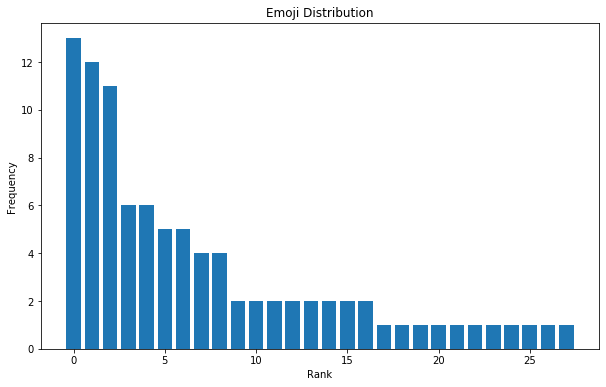

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_counts)), sorted_counts.values())
ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")
ax.set_title("Emoji Distribution")

del fig, ax

# Counting Data Streams
Now that we have worked with two ways of sampling data, some might think this is as far as we can go, but that is not quite true; we have counting data streams that allow us to compress the data further. We will be working with two counters, a bloom filter utilizing hashing, and a lossy counter.

Below is the class `HashFunction`, which generates a hash in the `__call__` function, which returns two hashes added together following the slots modulus.

In [13]:
class HashFunction:
    def __init__(self, num_slots):
        self.num_slots = num_slots
        
    def __call__(self, x):
        return (hash(self) + hash(x)) % self.num_slots

h1, h2 = HashFunction(7919), HashFunction(7919)

print(h1("😂"), h2("😂")) # The two hash functions are distinct, but both are deterministic

del h1, h2

2931 2847


# Bloom Filters
A bloom filter is a space-efficient probabilistic data structure. Because of the hash functions utilized, some hashes can overlap. We can see this with some of the emojis that we input; the chances are that some of them will overlap. A benefit to this is that the hashes allow for all of this information to be highly compressed. Two things that we can say from the bloom filter are:

that an item has not appeared in the data stream so far; or
that an item has possibly appeared in the data stream so far.

The class `BloomFilter` contains two functions, `check_appearance` and `do_filtering`. `do_filtering` iterates through the stream of Tweets, extracts the emojis, and passes the individual emojis into the `HashFunction`. The `check_appearance` function is not required to continue, and it is simply a way to ask if an emoji that has possibly appeared in the data stream has appeared so far. 

In [14]:
class BloomFilter:
    def __init__(self, num_slots, num_hash_fns):
        self.slots = np.zeros(num_slots, dtype=int)
        self.hash_fns = [HashFunction(num_slots) for _ in range(num_hash_fns)] # A list of distinct hash functions
    
    def check_appearance(self, item):
        '''
        Returns a bool value indicating whether an item has appeared or not
        '''
        test_hashes = np.zeros(num_hash_fns)
        for hash_item in range(len(self.hash_fns)):
            if self.slots[self.hash_fns[hash_item](item)] == 1:
                test_hashes[hash_item] = 1
                
        if np.count_nonzero(test_hashes) != 5:
            return False
        else:
            return True
    
    def do_filtering(self, stream):
        '''
        Iterates over a stream, collects items of interest, calculates the fingerprints and records the appearance
        '''
        self.slots = np.zeros_like(self.slots) # reset the slots
        
        for item in stream:
            emojis = extract_emojis(item)
            for emoji in emojis:
                for hash_item in range(len(self.hash_fns)):
                    self.slots[self.hash_fns[hash_item](emoji)] = 1

            yield self.slots.copy()

In [15]:
num_slots, num_hash_fns = 7919, 5
bloom_filter = BloomFilter(num_slots, num_hash_fns)

emojis_appeared = set()
for tweet in tweets:
    emojis_appeared = emojis_appeared.union(extract_emojis(tweet))
emojis_not_appeared = set(UNICODE_EMOJI.keys()) - emojis_appeared

for _ in bloom_filter.do_filtering(tweets):
    pass

print(emojis_appeared)

{'😕', '💀', '🛑', '🔸', '🍾', '🍁', '😤', '🏾', '🥺', '🗣', '🏻', '🔁', '💪', '〰', '🏿', '🗓', '😳', '😊', '👉', '\U0001f7e1', '🥶', '📌', '🤾', '🏒', '🖼', '❌', '😜', '🤭', '💬', '😁', '📰', '🏴', '⚫', '💸', '🍓', '💎', '🎬', '🎯', '⤵', '✨', '🔗', '👇', '🤯', '🌟', '👆', '💵', '📝', '⤴', '🎙', '✍', '💰', '😹', '🤩', '🐑', '😨', '📍', '🚏', '💣', '🦁', '🔜', '❤', '🐐', '🔥', '📡', '☺', '🏁', '🏑', '🤡', '🧬', '😱', '‼', '🌞', '🎟', '🔽', '😭', '♂', '🦱', '🐻', '🆘', '⚠', '🎧', '😎', '⏱', '🚨', '🤨', '⚽', '👻', '🔔', '👀', '⁉', '▪', '🌄', '👈', '🏆', '🤣', '🌅', '🎾', '✅', '☀', '🎫', '🏃', '🏀', '♀', '🏼', '🔋', '👨', '❎', '🤦', '🦍', '🤬', '☠', '🎥', '🦌', '📸', '🗼', '\U0001f7e9', '🍳', '🎤', '🎮', '🏝', '📲', '⛹', '🙃', '🌴', '🙏', '🥊', '😬', '🏄', '😆', '👊', '🙌', '\U0001f9a7', '📜', '\U0001f7e2', '🆚', '🤷', '💯', '👩', '👑', '👏', '😐', '✊', '🤗', '💛', '🤔', '🤖', '👌', '🔃', '⚾', '💻', '😅', '🔴', '🦅', '📺', '🤸', '🚴', '💚', '😞', '🦚', '🎉', '🏅', '🔵', '🖖', '🏽', '📈', '▶', '💭', '➡', '😂', '🤘', '🤴', '⛳', '♾', '💍', '💕', '📣', '⭐', '🙈', '🍛', '💥', '🥒', '\U0001f9be', '🐳', '🔌', '👎', '📄', '🤑'}


# Lossy Counter
The lossy counter is a very simple function that identifies elements in a data stream whose frequency count exceeds a user-given threshold. It works by adding the data into buckets for frequent items.

The `LossyCounter` has a single function, `do_counting`, that iterates through the streamed Twitter data and adds the Tweet emojis to a bucket.  If the function is dropping an emoji, it's not enough to set the count of that emoji to zero. The emoji must be completely deleted from the counts. 

In [16]:
class LossyCounter:
    
    def __init__(self, bucket_size):
        
        self.bucket_size = bucket_size
        self.counts = defaultdict(int) # recommended to use defaultdict, but an ordinary dict works fine too
    
    def do_counting(self, stream):
        """
        Iterates over a stream, counts the items and drops the infrequent ones in a bucket
        """
        
        self.counts.clear() # reset the counts
        num_items_in_bucket = 0 # optional: the current number of items in the "bucket"
        
        bucket = []
        for item in stream: # iterate over the stream   
            emojis = extract_emojis(item)
            for emoji in emojis:
                bucket.append(emoji)
            num_items_in_bucket += 1
            
            if num_items_in_bucket == self.bucket_size:
                for emoji in bucket:
                    self.counts[emoji] = self.counts.get(emoji, 0) + 1
                
                self.counts = {k: y - 1 for k, y in self.counts.items()}
                self.counts = {k: y for k, y in self.counts.items() if y!=0}
                bucket = []
                num_items_in_bucket = 0   
            yield self.counts.copy()
            
        if len(self.counts) == 0:
            for item in stream:
                emojis = extract_emojis(item)
                for emoji in emojis:
                    self.counts[emoji] = self.counts.get(emoji, 0) + 1
                    
            yield self.counts.copy()

In [17]:
bucket_size = 100000
lossy_count = LossyCounter(bucket_size)

# Collect all emojis that appeared
emojis_appeared = set()
for tweet in tweets:
    emojis_appeared = emojis_appeared.union(extract_emojis(tweet))

# Do counting. Don't have to collect the results. Just exhaust the stream
for _ in lossy_count.do_counting(tweets):
    pass

print(lossy_count.counts)

defaultdict(<class 'int'>, {'🔗': 2, '❤': 199, '🔥': 191, '🤯': 7, '🗣': 183, '🚨': 72, '🔴': 2, '🏀': 116, '🎫': 13, '🤖': 1, '\U0001f9be': 2, '🤭': 1, '😱': 13, '🔌': 89, '🔋': 83, '🏆': 72, '🔸': 10, '🐐': 5, '👏': 15, '🤗': 3, '😂': 34, '🏝': 4, '🤣': 21, '😨': 1, '🔔': 41, '🔃': 41, '🏁': 5, '🚴': 4, '⚽': 10, '🎾': 6, '▶': 18, '‼': 15, '⭐': 1, '☀': 3, '🦌': 4, '👉': 18, '👈': 18, '💀': 9, '📌': 2, '🤔': 8, '📰': 1, '💥': 14, '👇': 13, '🏾': 14, '👀': 32, '⚫': 7, '\U0001f7e1': 7, '\U0001f7e2': 7, '💵': 31, '💪': 16, '🤷': 5, '🏽': 9, '♂': 7, '😆': 6, '😎': 2, '\U0001f7e9': 2, '📲': 6, '💭': 1, '✍': 6, '🏻': 7, '😅': 9, '🙏': 2, '♾': 2, '🤴': 1, '🏿': 9, '🤡': 2, '😳': 12, '💰': 33, '👨': 12, '🦱': 9, '👩': 3, '😹': 1, '🐳': 1, '😬': 3, '👑': 2, '🍾': 1, '🤨': 1, '🥶': 2, '👌': 1, '😐': 1, '💯': 3, '📍': 1, '🌄': 1, '⛹': 1, '🌴': 1, '😭': 16, '🤦': 2, '♀': 2, '👎': 1, '😁': 2, '💎': 1, '✨': 3, '🌟': 6, '💕': 1, '⤵': 1, '🦚': 6, '🐻': 1, '💸': 3, '🎉': 4, '📈': 5, '🙈': 2, '❌': 1, '🤑': 2, '🚏': 1, '👆': 1, '🏅': 2, '🦅': 1, '☺': 2, '🎥': 6, '🛑': 9, '⚾': 3, '😤': 1, '🆘': 

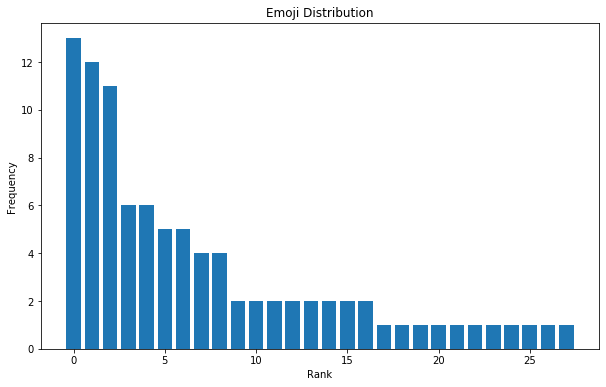

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_counts)), sorted_counts.values())
ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")
ax.set_title("Emoji Distribution")

del fig, ax